In [311]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [312]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from skimage import color, io

In [313]:
from concurrent.futures import ThreadPoolExecutor

In [314]:
from PIL import Image

# Increase the maximum allowed image pixels
Image.MAX_IMAGE_PIXELS = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


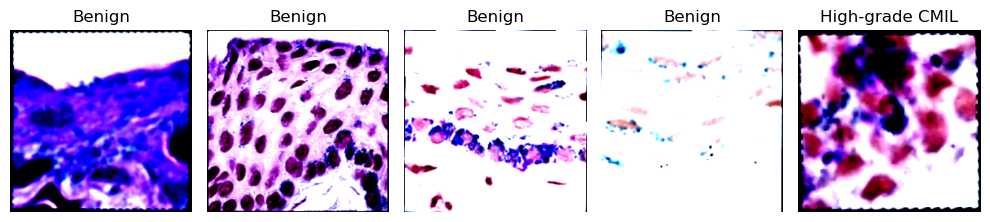


Train Set: Total Patches = 4406
  Benign (0):      1729
  High-grade (1):  2677

Validation Set: Total Patches = 3654
  Benign (0):      569
  High-grade (1):  3085

Test Set: Total Patches = 3572
  Benign (0):      2001
  High-grade (1):  1571


In [315]:
# === Step 1: Load and clean labels ===
labels = pd.read_csv('/Users/harveywang/Downloads/case_grade_match.csv')
labels = labels.drop(index=64, errors='ignore').reset_index(drop=True)

# === Step 2: Group patches by case number ===
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            case_patches.setdefault(case_num, []).append(os.path.join(patch_dir, filename))
    return case_patches

# === Step 3: Define Dataset class ===
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for case_num, paths in case_patches.items():
            label_row = labels_df[labels_df['Case'] == case_num]
            if not label_row.empty:
                label = label_row['BinaryClass'].values[0]
                for patch_path in paths:
                    self.image_paths.append(patch_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# === Step 4: Transforms ===
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Step 5: Load patches and filter labels ===
image_folder_path = '/Users/harveywang/Library/CloudStorage/GoogleDrive-harveywang2026@u.northwestern.edu/My Drive/Northwestern/Coursework/2025 Spring/STAT 390/CMIL_SP2025_Patches_Apr27'
patches = group_patches(image_folder_path)

# Filter for only the "good" cases
good_benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
good_high_grade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]
good_cases = set(good_benign_cases + good_high_grade_cases)

labels = labels[labels['Case'].isin(good_cases) & labels['Class'].isin([1.0, 3.0, 4.0])].copy()
labels['BinaryClass'] = labels['Class'].map({1.0: 0, 3.0: 1, 4.0: 1})

# Filter patch dictionary to good cases
patches = {case: paths for case, paths in patches.items() if case in good_cases}

case_classes = labels.drop_duplicates('Case').set_index('Case')['BinaryClass'].to_dict()
patch_counts = {case: len(patches[case]) for case in patches if case in case_classes}

# === Step 6: Split into train/val/test with class balance ===
from random import seed, shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

seed(42)

# Split cases by class
benign_cases = [c for c in good_benign_cases if c in patch_counts]
high_grade_cases = [c for c in good_high_grade_cases if c in patch_counts]

shuffle(benign_cases)
shuffle(high_grade_cases)

# Choose balanced splits: 60% train, 20% val, 20% test
def split_cases(case_list):
    n = len(case_list)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    return (
        case_list[:n_train],
        case_list[n_train:n_train + n_val],
        case_list[n_train + n_val:]
    )

train_benign, val_benign, test_benign = split_cases(benign_cases)
train_high, val_high, test_high = split_cases(high_grade_cases)

train_cases = train_benign + train_high
val_cases = val_benign + val_high
test_cases = test_benign + test_high

# === Step 7: Match patches to splits ===
train_patches = {c: patches[c] for c in train_cases}
val_patches = {c: patches[c] for c in val_cases}
test_patches = {c: patches[c] for c in test_cases}

# === Step 8: Create datasets and loaders ===
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=eval_transform)
test_dataset = PNGDataset(test_patches, labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Step 9: Visualize sample images ===
images, labels_batch = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels_batch[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# === Step 10: Print class distribution per split ===
def print_loader_stats(name, dataset):
    counts = Counter(dataset.labels)
    print(f"\n{name} Set: Total Patches = {len(dataset)}")
    print(f"  Benign (0):      {counts.get(0, 0)}")
    print(f"  High-grade (1):  {counts.get(1, 0)}")

print_loader_stats("Train", train_dataset)
print_loader_stats("Validation", val_dataset)
print_loader_stats("Test", test_dataset)

In [316]:
def print_case_list(set_name, case_list, case_classes):
    print(f"\n{set_name} Cases:")
    for case in sorted(case_list):
        label = case_classes.get(case, 'Unknown')
        label_str = 'Benign (0)' if label == 0 else 'High-grade (1)'
        print(f"  Case {case}: {label_str}")

# === Print case IDs and labels for each split ===
print_case_list("Train", train_cases, case_classes)
print_case_list("Validation", val_cases, case_classes)
print_case_list("Test", test_cases, case_classes)


Train Cases:
  Case 1: High-grade (1)
  Case 12: High-grade (1)
  Case 34: Benign (0)
  Case 45: Benign (0)
  Case 49: High-grade (1)
  Case 53: Benign (0)
  Case 55: High-grade (1)
  Case 70: High-grade (1)
  Case 78: Benign (0)
  Case 99: High-grade (1)

Validation Cases:
  Case 38: High-grade (1)
  Case 85: Benign (0)
  Case 98: High-grade (1)

Test Cases:
  Case 2: Benign (0)
  Case 3: High-grade (1)
  Case 9: High-grade (1)
  Case 79: Benign (0)
  Case 92: High-grade (1)


In [317]:
# Define validation loss and accuracy

def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [318]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=3,
                scheduler=None, resume_from=None, device='cuda' if torch.cuda.is_available() else 'cpu'):

    train_losses = []
    val_losses = []
    val_accuracies = []

    model_dir = "./models_5_12_1"
    os.makedirs(model_dir, exist_ok=True)

    model.to(device)
    best_acc = 0
    start_epoch = 0

    # Resume from checkpoint if specified
    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for images, labels in train_bar:
            images = [img.to(device) for img in images]
            labels = labels.to(device)
            images = torch.stack(images)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)

        # Step the learning rate scheduler if present
        if scheduler:
            scheduler.step()

        # Validation
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            correct = 0
            total = 0

            for images, labels in val_loader:
                images = [img.to(device) for img in images]
                labels = labels.to(device)
                images = torch.stack(images)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_val_loss = validation_loss / len(val_loader)
            val_accuracy = correct / total

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.3f}.. "
            f"Val Loss: {avg_val_loss:.3f}.. "
            f"Val Accuracy: {val_accuracy:.3f}"
        )

        # Save checkpoint
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"model_epoch_{e+1}.pth"))

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pth"))
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

        train_losses.append(epoch_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [319]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"../checkpoint/{timestamp}_{arch}.pth")
     

In [320]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv1(x))

class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

# ----------------- RESNET50 WITH CBAM ----------------- #
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        base = models.resnet50(pretrained=True)
        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            CBAM(256),
            base.layer2,
            CBAM(512),
            base.layer3,
            CBAM(1024),
            base.layer4,
            CBAM(2048),
        )
        self.avgpool = base.avgpool
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Instantiate model
model = ResNetCBAM(num_classes=2)

# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/harveywang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/harveywang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [321]:
# Loss function: CrossEntropyLoss (expects raw logits)
criterion = nn.CrossEntropyLoss()

# Optimizer: only update the final fully connected layer (fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Epoch 1/3: 100%|██████████| 138/138 [19:20<00:00,  8.41s/it, loss=0.511]


Epoch: 1/3.. Train Loss: 0.511.. Val Loss: 0.604.. Val Accuracy: 0.646
✅ New best model saved at epoch 1 with accuracy 0.6464


Epoch 2/3: 100%|██████████| 138/138 [20:25<00:00,  8.88s/it, loss=0.396]


Epoch: 2/3.. Train Loss: 0.396.. Val Loss: 0.722.. Val Accuracy: 0.555


Epoch 3/3: 100%|██████████| 138/138 [20:25<00:00,  8.88s/it, loss=0.356]


Epoch: 3/3.. Train Loss: 0.356.. Val Loss: 0.700.. Val Accuracy: 0.593


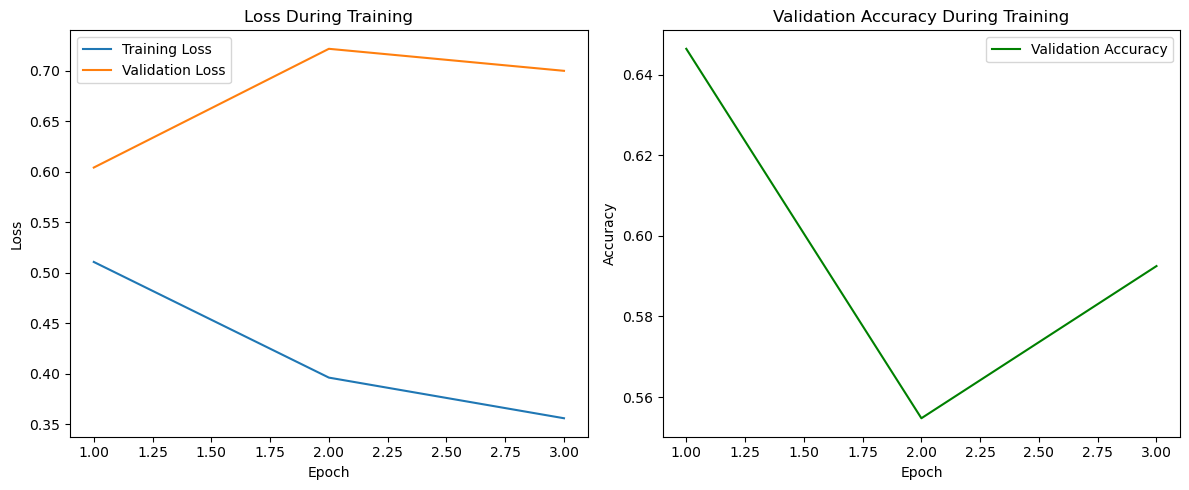

In [322]:
# Train model
resnet_model = train_model(model, optimizer, criiterion, train_loader, val_loader)

In [338]:
# Instantiate and load
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetCBAM(num_classes=2).to(device)

# Load trained weights
model.load_state_dict(torch.load('/Users/harveywang/models_5_12_1/best_model.pth', map_location=device))
model.eval()

ResNetCBAM(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [339]:
def get_predictions(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [341]:
# Get true and predicted labels
true_labels, pred_labels = get_predictions(model, test_loader) 

In [342]:
# If binary classification, use average='binary'; for multiclass use 'macro' or 'weighted'
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')
accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7413
Precision: 0.6759
Recall:    0.7912
F1 Score:  0.7290


In [343]:
print(set(pred_labels))  # Should be {0, 1} ideally


{0, 1}


In [344]:
from collections import Counter
print(Counter(train_dataset.labels))

Counter({1: 2677, 0: 1729})


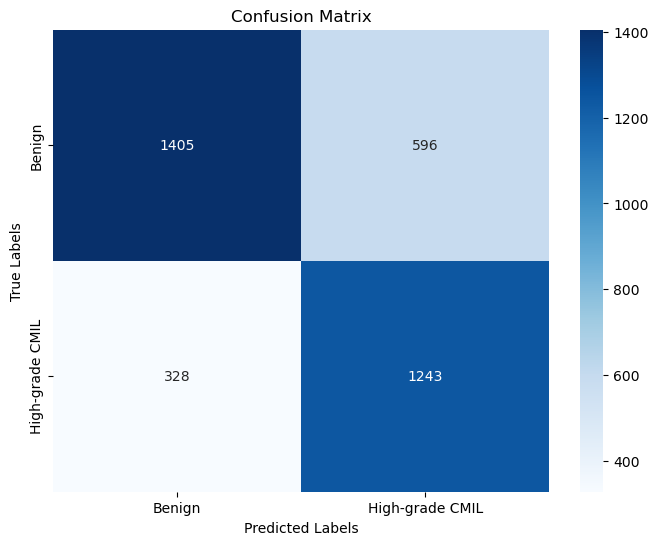

In [345]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [346]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.81      0.70      0.75      2001
   Malignant       0.68      0.79      0.73      1571

    accuracy                           0.74      3572
   macro avg       0.74      0.75      0.74      3572
weighted avg       0.75      0.74      0.74      3572



/Users/harveywang/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


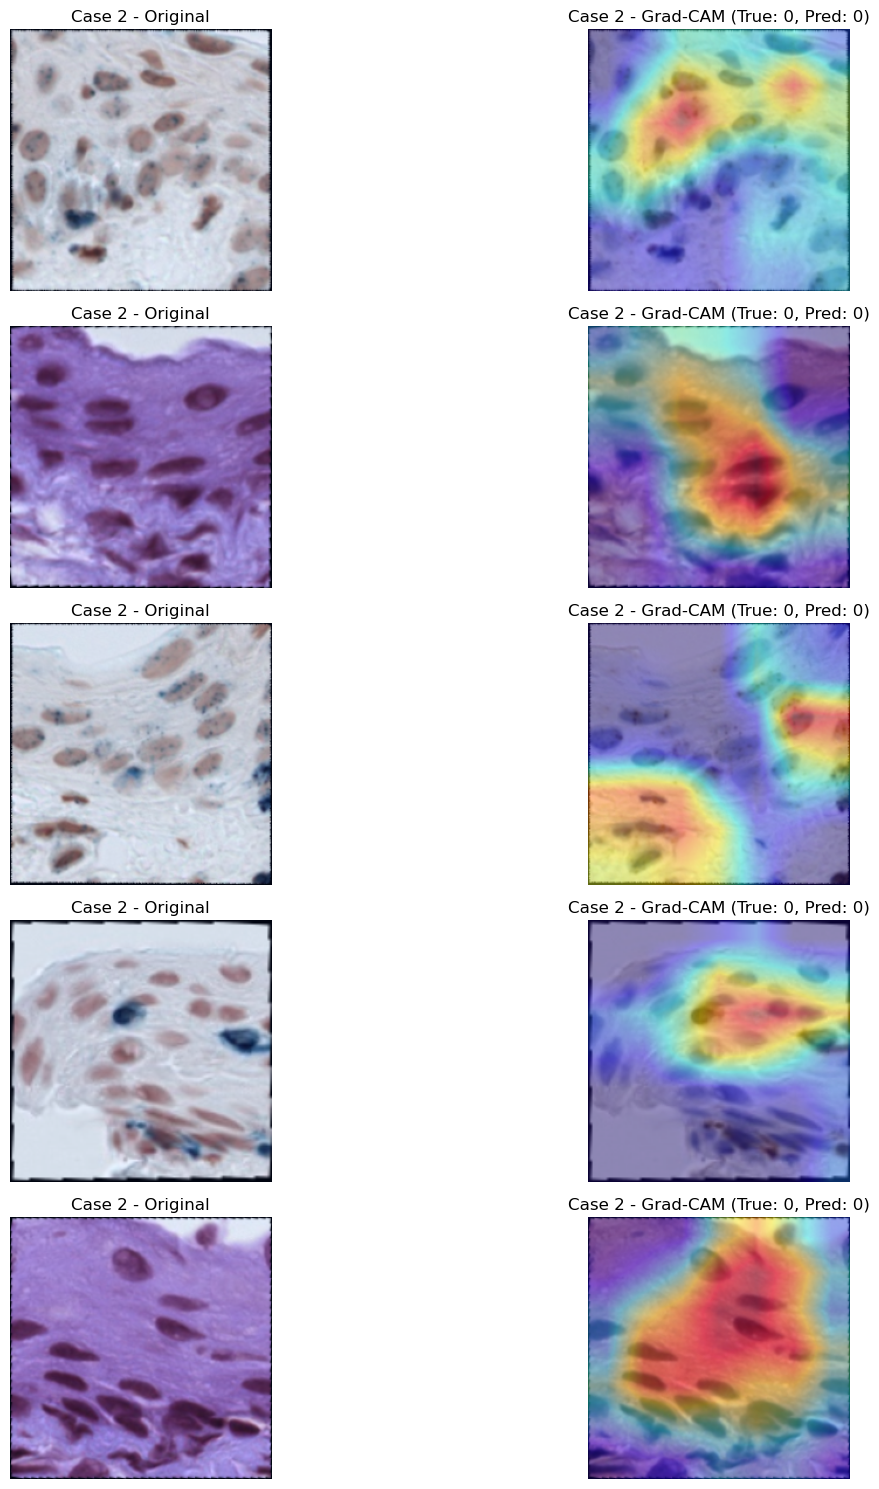

In [347]:
import cv2
from torchvision import transforms
from torch.nn import functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[:, class_idx].sum()
        self.model.zero_grad()
        loss.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()
        return grad_cam_map

# Instantiate Grad-CAM using final bottleneck block
target_layer = model.features[10][-1]
cam = GradCAM(model, target_layer)

# Process first 5 patches in test loader
num_images = 5
image_batch, label_batch = next(iter(test_loader))

plt.figure(figsize=(15, 3 * num_images))
for i in range(num_images):
    input_tensor = image_batch[i].unsqueeze(0)
    label = label_batch[i].item()
    pred_class = model(input_tensor).argmax().item()
    
    heatmap = cam.generate(input_tensor)
    
    img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap_img = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap_img, 0.4, 0)

    # Extract case number if filename or metadata available
    try:
        filename = test_loader.dataset.image_paths[i]
        case_match = re.search(r"case_(\d+)", filename)
        case_str = f"Case {case_match.group(1)}" if case_match else "Unknown Case"
    except:
        case_str = "Unknown Case"

    # Plot original and overlay
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{case_str} - Original")

    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(overlay[..., ::-1])
    plt.axis('off')
    plt.title(f"{case_str} - Grad-CAM (True: {label}, Pred: {pred_class})")

plt.tight_layout()
plt.show()